In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My\ Drive/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive


In [4]:
import pickle
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate, LSTM, Bidirectional
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

In [ ]:
## load in the data
with open('edited5.pkl', 'rb') as f:
  dataset = pickle.load(f)
dataset

In [6]:
df = pd.DataFrame(dataset)

In [7]:
df

,user_id,product_id,product_name,skin_type,rating,review,userId,product_idx
0,1,1,Vitamin C Serum,acne,0.9798,moisturize every day things aveeno drugstorebu...,0,0
1,1,2,The Ordinary,acne,0.9798,moisturize every day things aveeno drugstorebu...,0,1
2,1,3,niacinamide,acne,0.9798,moisturize every day things aveeno drugstorebu...,0,2
3,1,4,salicylic acid,acne,0.9798,moisturize every day things aveeno drugstorebu...,0,3
4,1,5,vitamin C,acne,0.9798,moisturize every day things aveeno drugstorebu...,0,4
...,...,...,...,...,...,...,...,...
115243,23122,4,salicylic acid,acne,0.9872,ive used glow tonic impressed formulated prope...,23121,3
115244,23122,5,vitamin C,acne,0.9872,ive used glow tonic impressed formulated prope...,23121,4
115245,23123,15,cerave,acne,-0.8552,cerave cleanser moisturizer treat acne acne sp...,23122,14
115246,23123,4,salicylic acid,acne,-0.8552,cerave cleanser moisturizer treat acne acne sp...,23122,3


In [8]:
N = df.userId.max() + 1 # number of users
M = df.product_idx.max() + 1 # number of product

In [9]:
# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [10]:
# tokenizing word and converting into sequences.
vocab_size = 1000
embedding_dim = 128
max_length = 400
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df_train['review'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df_train['review'])
review_padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(df_test['review'])
review_testing_padded = pad_sequences(testing_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)



In [11]:
# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 10
reg = 0.0001 # regularization penalty

In [12]:
# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
x = Concatenate()([u_embedding, m_embedding]) # (N, 2K)

review_input = Input(shape=(max_length, ))
review_embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(review_input)
review_embedding = Bidirectional(LSTM(100, dropout = 0.2))(review_embedding)
review_final = Dense(100, activation='tanh', name ="doc_latent_vector")(review_embedding)
merged = Concatenate()([x, review_final])

# the neural network
x = Dense(400)(merged)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(100)(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(1)(x)

model = Model(inputs=[u, m, review_input], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mean_squared_error'],)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        231230      input_1[0][0]                    
_______________________________________________________________________________________

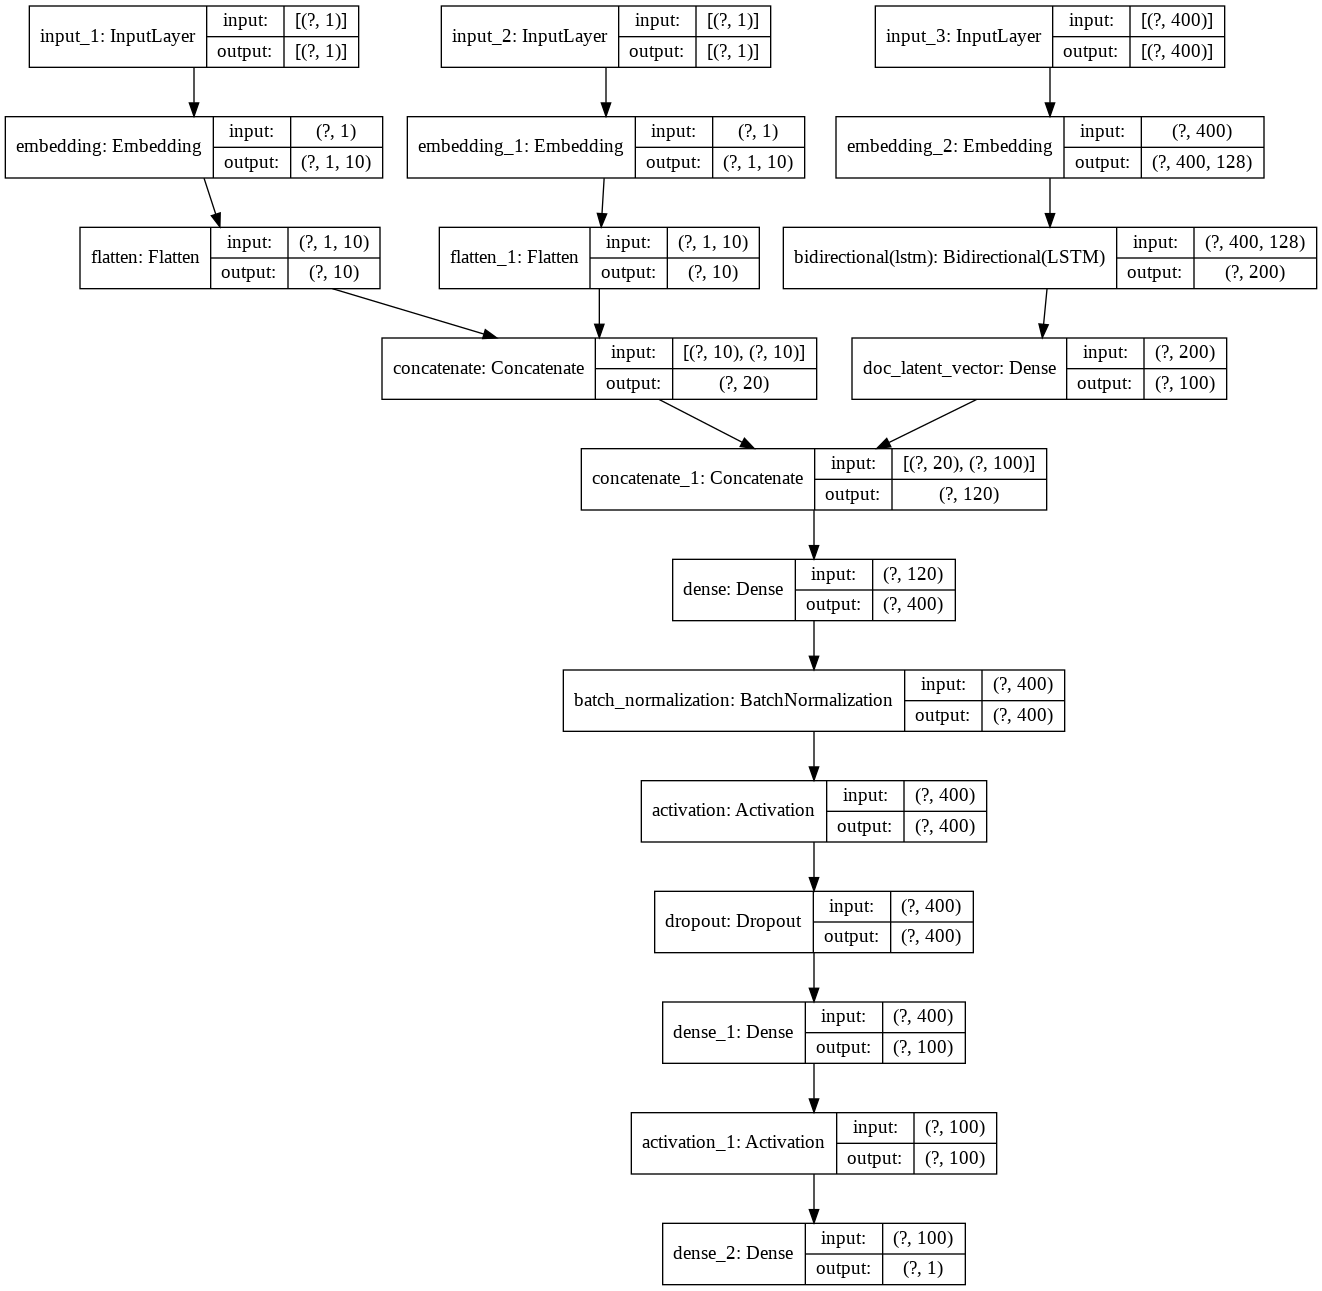

In [13]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True
)

Epoch 1/10
721/721 [==============================] - 1658s 2s/step - loss: 0.4060 - mean_squared_error: 0.4060 - val_loss: 0.4534 - val_mean_squared_error: 0.4534
Epoch 2/10
721/721 [==============================] - 1640s 2s/step - loss: 0.1734 - mean_squared_error: 0.1734 - val_loss: 0.1151 - val_mean_squared_error: 0.1151
Epoch 3/10
721/721 [==============================] - 1639s 2s/step - loss: 0.0572 - mean_squared_error: 0.0572 - val_loss: 0.1827 - val_mean_squared_error: 0.1827
Epoch 4/10
721/721 [==============================] - 1654s 2s/step - loss: 0.0382 - mean_squared_error: 0.0382 - val_loss: 0.2164 - val_mean_squared_error: 0.2164
Epoch 5/10
721/721 [==============================] - 1671s 2s/step - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.2539 - val_mean_squared_error: 0.2539
Epoch 6/10
721/721 [==============================] - 1670s 2s/step - loss: 0.0281 - mean_squared_error: 0.0281 - val_loss: 0.2102 - val_mean_squared_error: 0.2102
Epoch 7/10
721/7

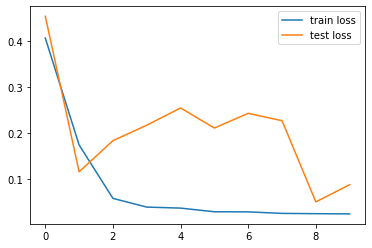

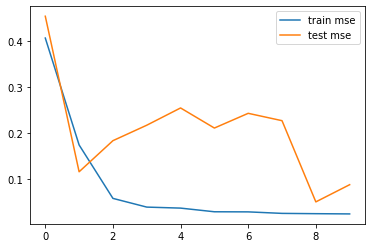

In [ ]:
r = model.fit(
  x=[df_train.userId.values, df_train.product_idx.values, review_padded],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.product_idx.values, review_testing_padded],
    df_test.rating.values - mu
  )
)


# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['mean_squared_error'], label="train mse")
plt.plot(r.history['val_mean_squared_error'], label="test mse")
plt.legend()
plt.show()

In [ ]:
model.evaluate([df_test.userId.values, df_test.product_idx.values, review_testing_padded], df_test.rating.values)

721/721 [==============================] - 89s 124ms/step - loss: 0.2589 - mean_squared_error: 0.2589


[0.2589057981967926, 0.2589057981967926]

In [ ]:
predictions = model.predict([df_test.userId.values, df_test.product_idx.values, review_testing_padded])

[print(predictions[i], df_test.rating.iloc[i]) for i in range(0,8)]
# [print(predictions[2], df_test.rating.iloc[2])]

[0.40625912] 0.989
[-1.4694998] -0.989
[0.43279114] 0.9974
[0.38371605] 0.9239
[-1.213764] -0.9844
[0.36799994] 0.6818
[0.39801192] 0.9463
[0.40779743] 0.9862


[None, None, None, None, None, None, None, None]

In [ ]:
# from keras.utils import plot_model
# plot_model(model)

# Recommending products

In [ ]:
dataset = pd.read_csv('edited_rating4.csv')


In [ ]:
dataset = df
dataset

In [ ]:
productdata = np.array(list(set(dataset.product_idx)))
productdata

In [ ]:
userdata = np.array([6 for i in range(len(productdata))])
userdata

In [ ]:
predictions = model.predict([userdata, productdata, ])
predictions = np.array([a[0] for a in predictions])

recommendedproducts = (-predictions).argsort()[:8]
recommendedproducts